# Convolutional Neural Networks

Up until transformers, convolutions were *the* state of the art in computer vision.  In many ways and applications they still are!

Large Language Models, which are what we'll focus on the rest of the series after this lecture, are really good at ordered, *tokenized data.  But there is lots of data that isn't _implicitly_ ordered like `images`, and their more general cousins `graphs`.

Today's lecture focuses on computer vision models, and particularly on convolutional neural networks.  There are a ton of applications you can do with these, and not nearly enough time to get into them.  Check out the extra references file to see some publications to get you started if you want to learn more.


## Convolutional Networks: A brief historical context

![ImageNet Accuracy by Yearh](ImageNet.png)

[reference](https://www.researchgate.net/publication/332452649_A_Roadmap_for_Foundational_Research_on_Artificial_Intelligence_in_Medical_Imaging_From_the_2018_NIHRSNAACRThe_Academy_Workshop)

In [2]:
import torch, torchvision

# Convolutional Building Blocks

We're going to go through some examples of building blocks for convolutional networks.  To help illustate some of these, let's use an image for examples:


In [3]:
from PIL import Image
alcf_image = Image.open("ALCF-Staff.jpg")

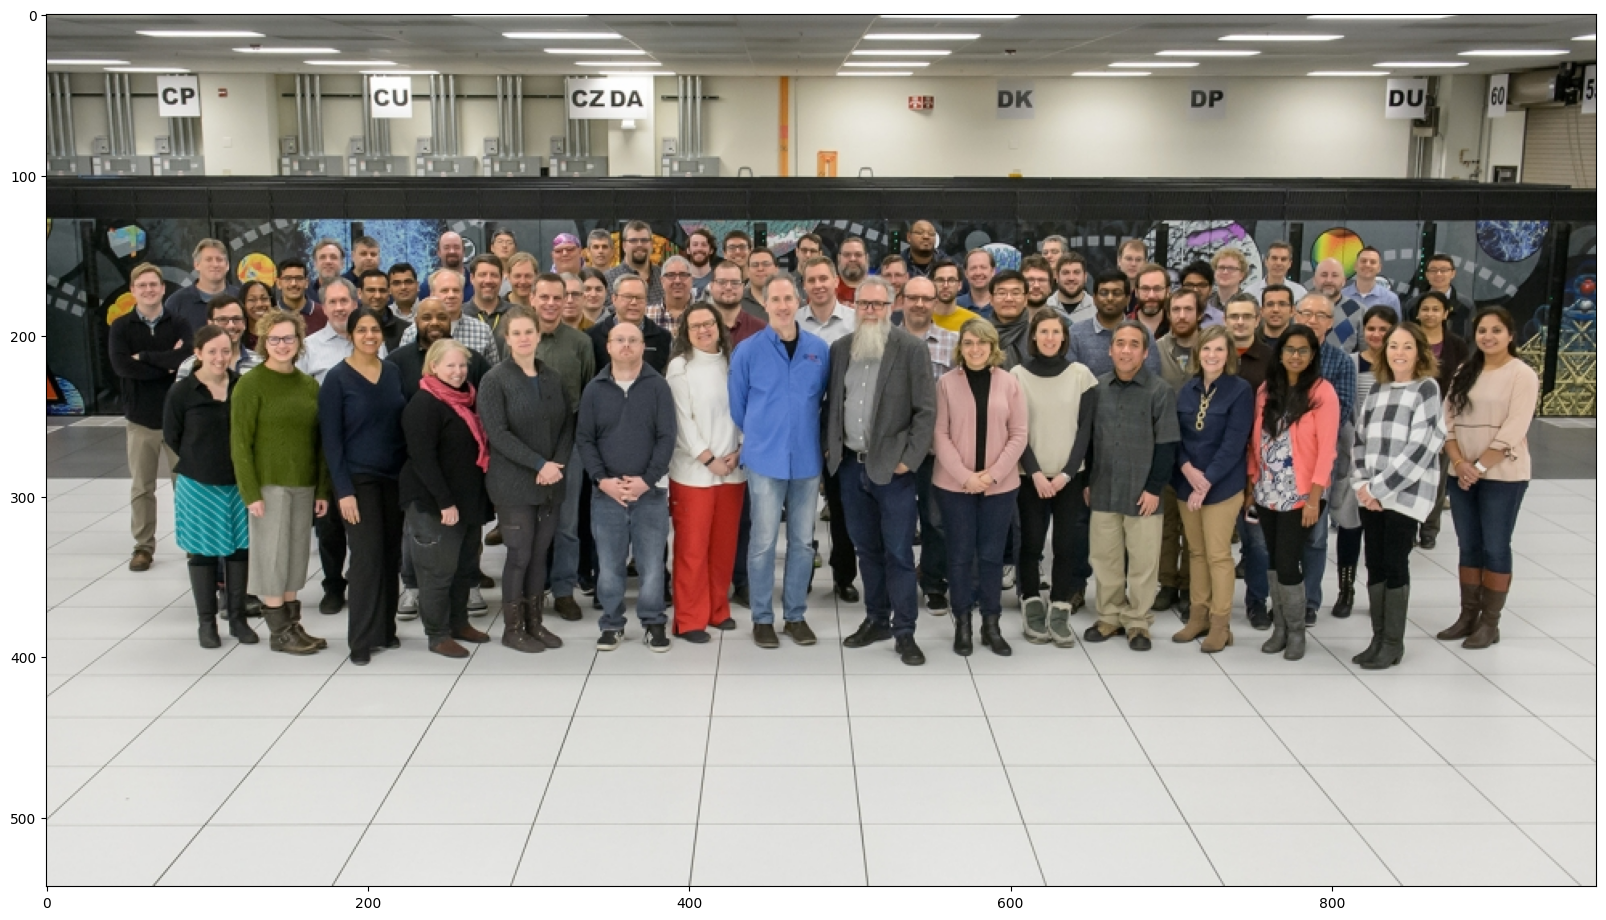

In [4]:
from matplotlib import pyplot as plt
figure = plt.figure(figsize=(20,20))
plt.imshow(alcf_image)
plt.show()

## Convolutions

Convolutions are a restriction of - and a specialization of - dense linear layers.  A convolution of an image produces another image, and each output pixel is a function of only it's local neighborhood of points.  This is called an _inductive bias_ and is a big reason why convolutions work for image data: neighboring pixels are correlated and you can operate on just those pixels at a time.

See examples of convolutions [here](https://github.com/vdumoulin/conv_arithmetic)

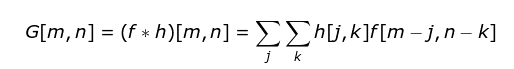

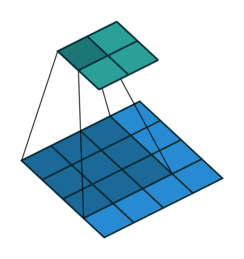


torch.Size([1, 3, 529, 951])
torch.Size([1, 3, 543, 965])


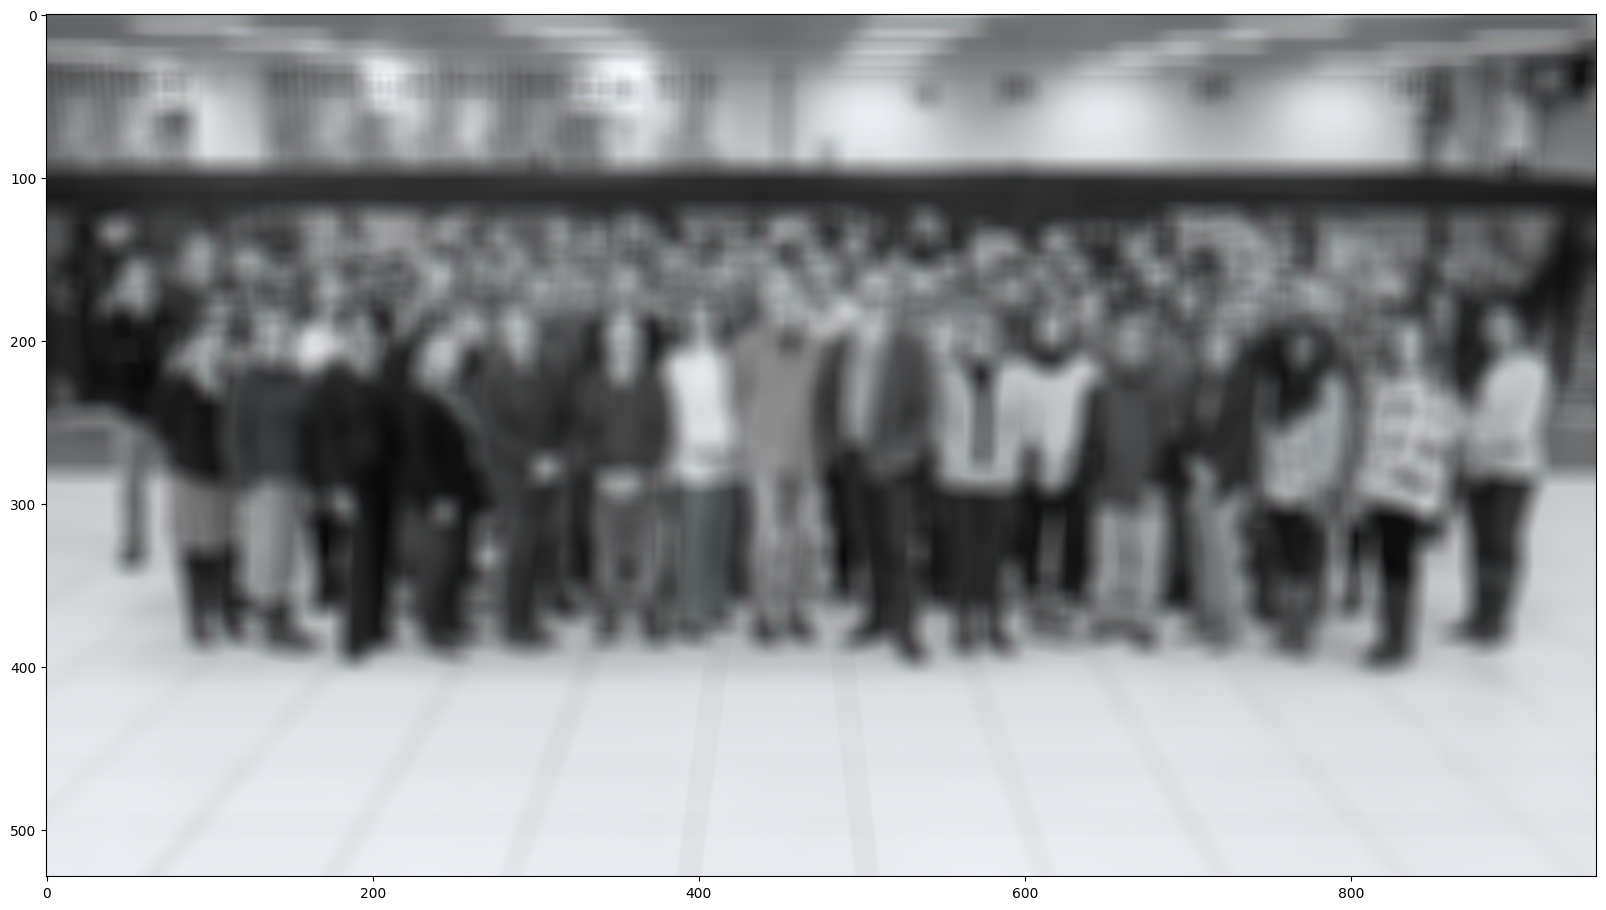

In [5]:
# Let's apply a convolution to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)

# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)

# Create a random convolution:
# shape is: (channels_in, channels_out, kernel_x, kernel_y)
conv_random = torch.rand((3,3,15,15))

alcf_rand = torch.nn.functional.conv2d(alcf_tensor, conv_random)
alcf_rand = (1./alcf_rand.max()) * alcf_rand
print(alcf_rand.shape)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])

print(alcf_tensor.shape)

rand_image = alcf_rand.permute((1,2,0)).cpu()

figure = plt.figure(figsize=(20,20))

plt.imshow(rand_image)


## Normalization

![Batch Norm](batch_norm.png)
Reference: [Normalizations](https://arxiv.org/pdf/1903.10520.pdf)

Normalization is the act of transforming the mean and moment of your data to standard values (usually 0.0 and 1.0).  It's particularly useful in machine learning since it stabilizes training, and allows higher learning rates.

![Batch Normalization accelerates training](batch_norm_effect.png)

Reference: [Batch Norm](https://arxiv.org/pdf/1502.03167.pdf)


torch.Size([1, 3, 543, 965])


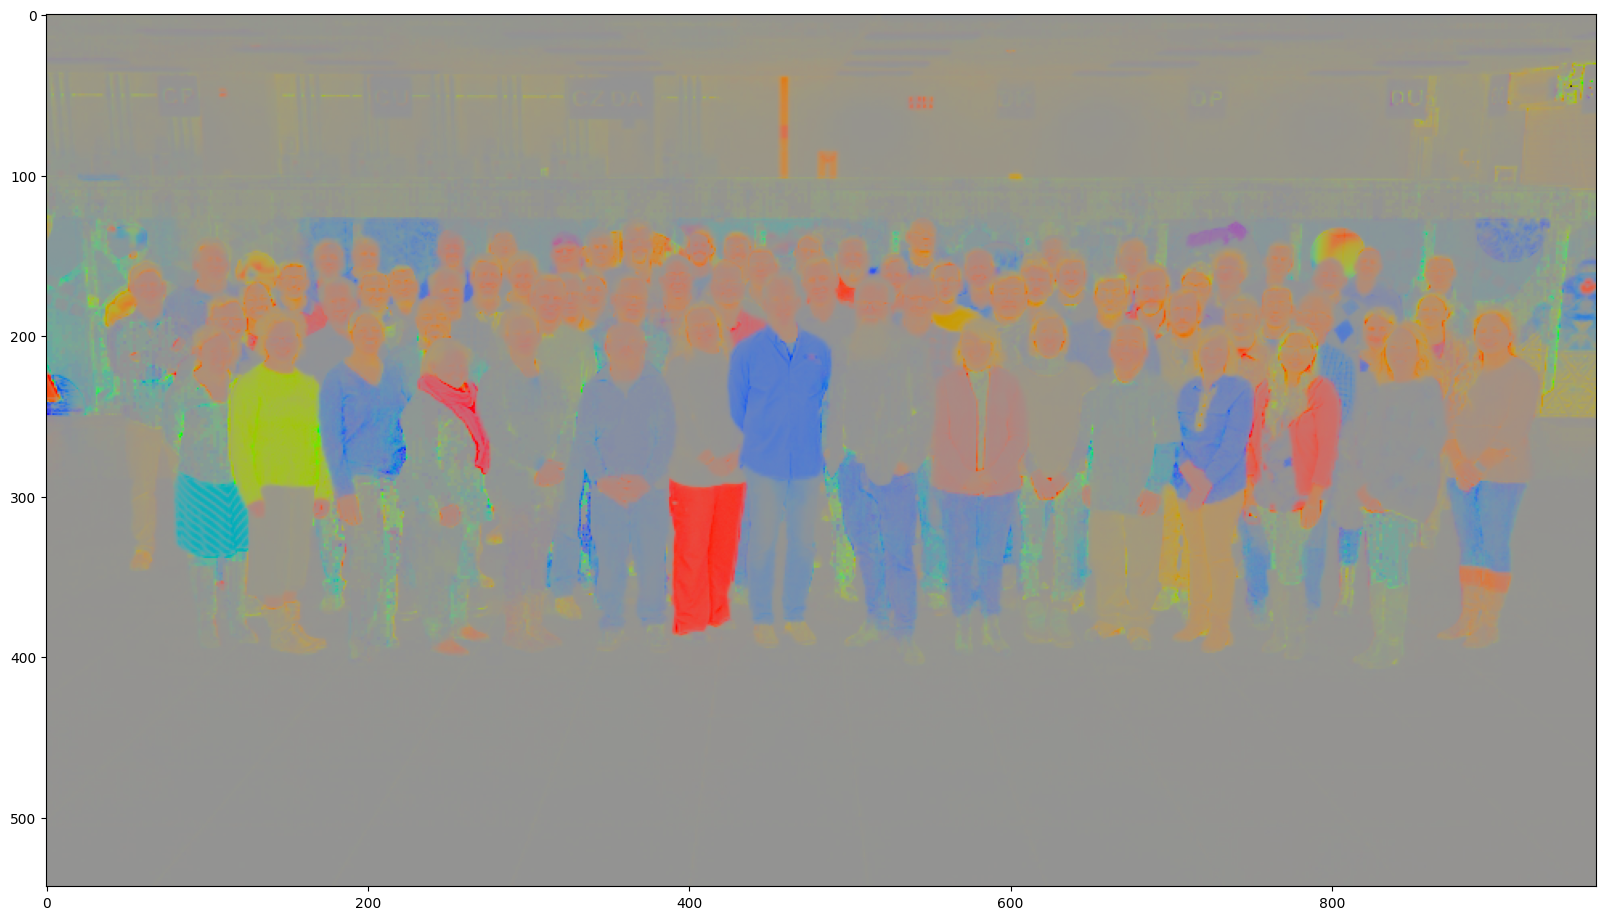

In [6]:
# Let's apply a normalization to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)

# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)


alcf_rand = torch.nn.functional.normalize(alcf_tensor)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])

print(alcf_tensor.shape)

rand_image = alcf_rand.permute((1,2,0)).cpu()

figure = plt.figure(figsize=(20,20))

plt.imshow(rand_image)



## Downsampling (And upsampling)

Downsampling is a critical component of convolutional and many vision models.  Because of the local-only nature of convolutional filters, learning large-range features can be too slow for convergence.  Downsampling of layers can bring information from far away closer, effectively changing what it means to be "local" as the input to a convolution.

![Convolutional Pooling](conv_pooling.png "Pooling")

[Reference](https://www.researchgate.net/publication/333593451_Application_of_Transfer_Learning_Using_Convolutional_Neural_Network_Method_for_Early_Detection_of_Terry's_Nail)



torch.Size([1, 3, 543, 965])


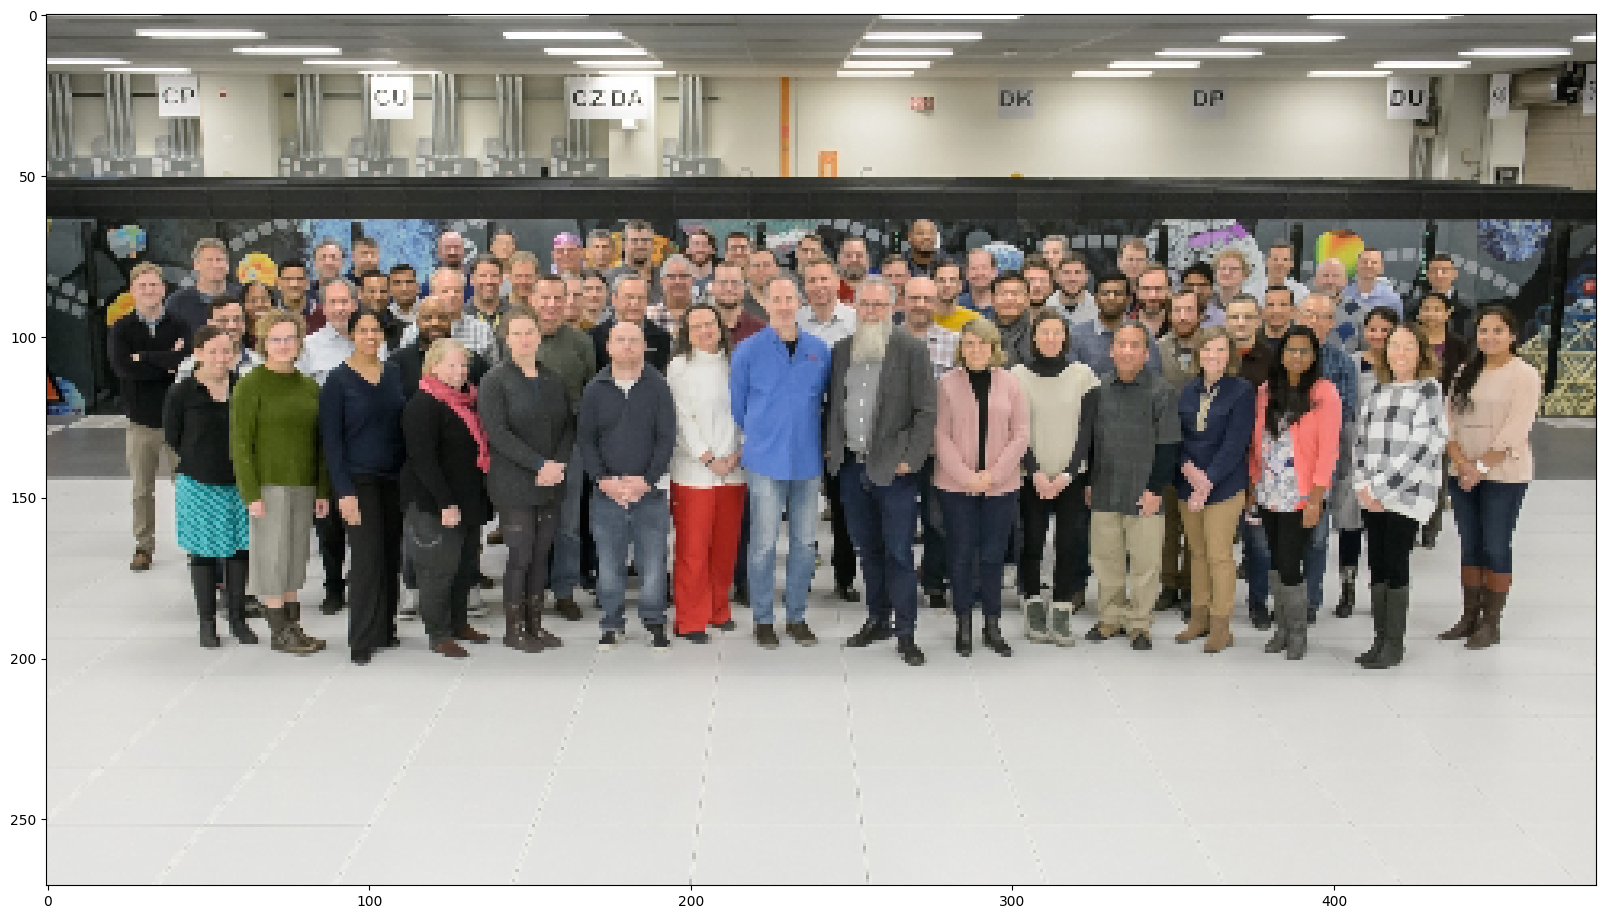

In [7]:
# Let's apply a normalization to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)

# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)


alcf_rand = torch.nn.functional.max_pool2d(alcf_tensor, 2)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])

print(alcf_tensor.shape)

rand_image = alcf_rand.permute((1,2,0)).cpu()

figure = plt.figure(figsize=(20,20))

plt.imshow(rand_image)


## Residual Connections

One issue, quickly encountered when making convolutional networks deeper and deeper, is the "Vanishing Gradients" problem.  As layers were stacked on top of each other, the size of updates dimished at the earlier layers of a convolutional network.  The paper "Deep Residual Learning for Image Recognition" solved this by introduction "residual connections" as skip layers.


Reference: [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)

![Residual Layer](residual_layer.png)


Compare the performance of the models before and after the introduction of these layers:

![Resnet Performance vs. Plain network performance](resnet_comparison.png)

If you have time to read only one paper on computer vision, make it this one!  Resnet was the first model to beat human accuracy on ImageNet and is one of the most impactful papers in AI ever published.

# Building a ConvNet

In this section we'll build and apply a conv net to the mnist dataset.  The layers here are loosely based off of the ConvNext architecture.  Why?  Because we're getting into LLM's soon, and this ConvNet uses LLM features.  ConvNext is an update to the ResNet architecture that outperforms it.

[ConvNext](https://arxiv.org/abs/2201.03545)


The dataset here is CIFAR-10 - slightly harder than MNIST but still relatively easy and computationally tractable.

In [8]:
from torchvision.transforms import v2
training_data = torchvision.datasets.CIFAR10(
    root="/lus/eagle/projects/datasets/CIFAR-10/",
    train=True,
    download=True,
    transform=v2.Compose([
        v2.ToTensor(),
        v2.RandomHorizontalFlip(),
        v2.RandomResizedCrop(size=32, scale=[0.85,1.0], antialias=False),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ])
)

test_data = torchvision.datasets.CIFAR10(
    root="/lus/eagle/projects/datasets/CIFAR-10/",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=True, 
    num_workers=4)
val_dataloader = torch.utils.data.DataLoader(validation_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=False, 
    num_workers=4)

/soft/datascience/conda/2023-10-04/mconda3/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/soft/datascience/conda/2023-10-04/mconda3/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

Files already downloaded and verified
Files already downloaded and verified


In [9]:
from matplotlib import pyplot as plt
%matplotlib inline

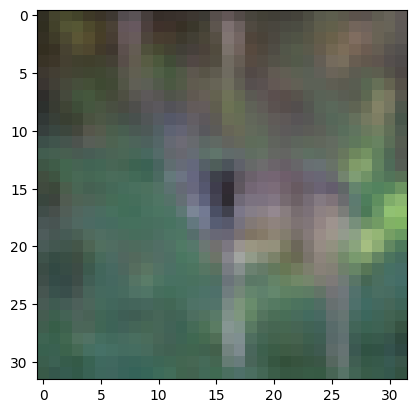

tensor(4)


In [10]:
batch, (X, Y) = next(enumerate(train_dataloader))
plt.imshow(X[0].cpu().permute((1,2,0))); plt.show()
print(Y[0])

This code below is important as our models get bigger: this is wrapping the pytorch data loaders to put the data onto the GPU!

In [11]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")
print(dev)

def preprocess(x, y):
    # CIFAR-10 is *color* images so 3 layers!
    return x.view(-1, 3, 32, 32).to(dev), y.to(dev)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))


train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
val_dataloader = WrappedDataLoader(val_dataloader, preprocess)

cuda


In [12]:
from torch import nn


class Downsampler(nn.Module):

    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])

        self.downsample = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels,
            kernel_size = stride,
            stride = stride,
        )
    
    def forward(self, inputs):


        return self.downsample(self.norm(inputs))
        
        

class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """


    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=in_channels, 
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=4*in_channels,
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=4*in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )


    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)

        # This makes it a residual network:
        return x + inputs
    

class Classifier(nn.Module):


    def __init__(self, n_initial_filters, n_stages, blocks_per_stage, patchify=1):
        super(Classifier, self).__init__()

        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=1,
                                    stride=1)
        
        current_shape = [32, 32]

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])
        # self.norm1 = WrappedLayerNorm()

        current_n_filters = n_initial_filters
        
        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters, 
                    out_channels=2*current_n_filters,
                    shape = current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]
            


        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10)
        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10, 
        #                                   kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x



        # x = self.norm2(x)
        # x = self.bottleneck(x)

        # # Average pooling of the remaining spatial dimensions (and reshape) makes this label-like:
        # return nn.functional.avg_pool2d(x, kernel_size=x.shape[-2:]).reshape((-1,10))

In [13]:
model = Classifier(64, 4, 2, 2)

model.cuda()

from torchinfo import summary

print(summary(model, input_size=(batch_size, 3, 32, 32)))


Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 64, 32, 32]         256
├─LayerNorm: 1-2                         [128, 64, 32, 32]         131,072
├─Sequential: 1-3                        [128, 512, 4, 4]          --
│    └─ConvNextBlock: 2-1                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 64, 32, 32]         3,200
│    │    └─LayerNorm: 3-2               [128, 64, 32, 32]         131,072
│    │    └─Conv2d: 3-3                  [128, 256, 32, 32]        16,640
│    │    └─Conv2d: 3-4                  [128, 64, 32, 32]         16,448
│    └─ConvNextBlock: 2-2                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-5                  [128, 64, 32, 32]         3,200
│    │    └─LayerNorm: 3-6               [128, 64, 32, 32]         131,072
│    │    └─Conv2d: 3-7                  [128, 256, 32,

In [14]:
def evaluate(dataloader, model, loss_fn, val_bar):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:

            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            val_bar.update()
            
    loss /= num_batches
    correct /= (size*batch_size)
    
    accuracy = 100*correct
    return accuracy, loss

In [15]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, progress_bar):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()      

        progress_bar.update()

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

In [ ]:
from tqdm.notebook import tqdm

epochs = 30
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)

    # checking on the training loss and accuracy once per epoch

    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
        acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)

        print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:

        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")
    

# Homework 1:

In this notebook, we've learned about some basic convolutional networks and trained one on CIFAR-10 images.  It did ... OK.  There is significant overfitting of this model.  There are some ways to address that, but we didn't have time to get into that in this session.

Meanwhile, your homework (part 1) for this week is to try to train the model again but with a different architecture.  Change one or more of the following:
- The number of convolutions between downsampling
- The number of filters in each layer
- The initial "patchify" layer
- Another hyper-parameter of your choosing


And compare your final validation accuracy to the accuracy shown here.  Can you beat the validation accuracy shown?

For full credit on the homework, you need to show (via text, or make a plot) the training and validation data sets' performance (loss and accuracy) for all the epochs you train.  You also need to explain, in several sentences, what you changed in the network and why you think it makes a difference.

In [17]:
class Classifier(nn.Module):


    def __init__(self, n_initial_filters, n_stages, blocks_per_stage, patchify=1):
        super(Classifier, self).__init__()

        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=patchify,
                                    stride=patchify)
        
        current_shape = [int(32/patchify), int(32/patchify)]

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])
        # self.norm1 = WrappedLayerNorm()

        current_n_filters = n_initial_filters
        
        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters, 
                    out_channels=2*current_n_filters,
                    shape = current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]
            


        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10)
        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10, 
        #                                   kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x

In [18]:
import numpy as np
from tqdm.notebook import tqdm
def training(model, loss_fn, optimizer, epochs, savefile):
    acc_loss = []
    for j in range(epochs):
        with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
            train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)

        # checking on the training loss and accuracy once per epoch

        with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
            acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)

            print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
        with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:

            acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
            print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")
    
        acc_loss.append([acc, loss, acc_val, loss_val])
    np.savetxt(savefile, acc_loss, header="acc_train\tloss_train\tacc_val\tloss_val")

In [24]:
model = Classifier(64, 4, 2, 1)
model.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

epoch = 20
savefile = "64_4_2_1.txt"
training(model, loss_fn, optimizer, epoch, savefile)

Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 1.657, accuracy: 39.220


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 1.643, accuracy: 39.656


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: training loss: 1.399, accuracy: 49.254


Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 1.416, accuracy: 48.240


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: training loss: 1.212, accuracy: 57.014


Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 1.243, accuracy: 55.489


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: training loss: 1.092, accuracy: 60.835


Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.149, accuracy: 58.238


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: training loss: 0.989, accuracy: 64.796


Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 1.084, accuracy: 60.690


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 0.844, accuracy: 70.562


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 0.982, accuracy: 65.477


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: training loss: 0.703, accuracy: 75.676


Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 0.857, accuracy: 68.888


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7: training loss: 0.613, accuracy: 78.474


Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 0.832, accuracy: 70.599


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8: training loss: 0.526, accuracy: 81.792


Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 0.772, accuracy: 72.488


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9: training loss: 0.492, accuracy: 82.788


Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 0.794, accuracy: 72.379


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 0.398, accuracy: 86.302


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 0.758, accuracy: 73.962


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11: training loss: 0.322, accuracy: 89.060


Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 0.728, accuracy: 75.287


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12: training loss: 0.309, accuracy: 89.260


Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 0.786, accuracy: 74.407


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13: training loss: 0.282, accuracy: 90.171


Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 0.794, accuracy: 74.980


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14: training loss: 0.222, accuracy: 92.407


Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 0.770, accuracy: 76.147


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 0.194, accuracy: 93.438


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 0.789, accuracy: 76.009


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16: training loss: 0.199, accuracy: 92.849


Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: validation loss: 0.831, accuracy: 75.890


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17: training loss: 0.165, accuracy: 94.204


Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: validation loss: 0.814, accuracy: 76.305


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18: training loss: 0.133, accuracy: 95.310


Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: validation loss: 0.830, accuracy: 76.958


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19: training loss: 0.140, accuracy: 95.185


Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: validation loss: 0.797, accuracy: 77.265


In [18]:
epoch = 20

for nfilter in [32, 128]:
    model = Classifier(nfilter, 4, 2, 1)
    model.cuda()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

    savefile = "%d_4_2_1.txt" % nfilter
    training(model, loss_fn, optimizer, epoch, savefile)
    
for nstage in [2, 6]:
    model = Classifier(64, nstage, 2, 1)
    model.cuda()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

    savefile = "64_%d_2_1.txt" % nstage
    training(model, loss_fn, optimizer, epoch, savefile)

for nconv in [1, 4]:
    model = Classifier(64, 4, nconv, 1)
    model.cuda()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

    savefile = "64_4_%d_1.txt" % nconv
    training(model, loss_fn, optimizer, epoch, savefile)

for patch in [2, 4]:
    model = Classifier(64, 4, 2, patch)
    model.cuda()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

    savefile = "64_4_2_%d.txt" % patch
    training(model, loss_fn, optimizer, epoch, savefile)

Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 1.644, accuracy: 39.966


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 1.639, accuracy: 39.943


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: training loss: 1.383, accuracy: 50.117


Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 1.394, accuracy: 49.001


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: training loss: 1.295, accuracy: 53.292


Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 1.324, accuracy: 51.572


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: training loss: 1.160, accuracy: 58.841


Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.210, accuracy: 56.477


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: training loss: 1.040, accuracy: 62.982


Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 1.125, accuracy: 59.187


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 0.908, accuracy: 67.964


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 1.022, accuracy: 63.380


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: training loss: 0.829, accuracy: 70.989


Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 0.966, accuracy: 65.566


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7: training loss: 0.749, accuracy: 73.745


Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 0.929, accuracy: 66.762


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8: training loss: 0.687, accuracy: 76.113


Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 0.914, accuracy: 67.464


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9: training loss: 0.627, accuracy: 78.125


Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 0.920, accuracy: 67.761


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 0.508, accuracy: 82.471


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 0.827, accuracy: 71.272


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11: training loss: 0.463, accuracy: 83.734


Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 0.839, accuracy: 71.549


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12: training loss: 0.480, accuracy: 83.222


Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 0.893, accuracy: 70.500


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13: training loss: 0.362, accuracy: 87.717


Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 0.838, accuracy: 72.271


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14: training loss: 0.349, accuracy: 87.872


Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 0.847, accuracy: 72.132


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 0.293, accuracy: 89.886


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 0.862, accuracy: 72.607


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16: training loss: 0.270, accuracy: 90.433


Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: validation loss: 0.896, accuracy: 73.161


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17: training loss: 0.225, accuracy: 92.267


Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: validation loss: 0.864, accuracy: 73.685


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18: training loss: 0.221, accuracy: 92.332


Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: validation loss: 0.890, accuracy: 73.418


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19: training loss: 0.197, accuracy: 93.056


Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: validation loss: 0.903, accuracy: 73.032


Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 1.975, accuracy: 26.213


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 1.973, accuracy: 25.969


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: training loss: 1.630, accuracy: 40.323


Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 1.624, accuracy: 39.695


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: training loss: 1.438, accuracy: 47.779


Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 1.452, accuracy: 47.320


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: training loss: 1.283, accuracy: 53.604


Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.317, accuracy: 51.553


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: training loss: 1.164, accuracy: 58.389


Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 1.210, accuracy: 55.756


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 1.012, accuracy: 63.913


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 1.102, accuracy: 59.474


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: training loss: 0.946, accuracy: 66.454


Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 1.079, accuracy: 61.966


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7: training loss: 0.780, accuracy: 72.749


Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 0.952, accuracy: 65.892


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8: training loss: 0.677, accuracy: 76.241


Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 0.890, accuracy: 68.345


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9: training loss: 0.556, accuracy: 80.908


Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 0.841, accuracy: 70.283


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 0.483, accuracy: 83.591


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 0.801, accuracy: 71.489


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11: training loss: 0.411, accuracy: 86.195


Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 0.801, accuracy: 72.142


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12: training loss: 0.358, accuracy: 87.717


Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 0.831, accuracy: 72.597


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13: training loss: 0.313, accuracy: 89.240


Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 0.861, accuracy: 72.290


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14: training loss: 0.288, accuracy: 90.038


Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 0.882, accuracy: 72.231


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 0.214, accuracy: 92.512


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 0.854, accuracy: 73.991


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16: training loss: 0.220, accuracy: 92.340


Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: validation loss: 0.877, accuracy: 73.556


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17: training loss: 0.175, accuracy: 94.040


Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: validation loss: 0.878, accuracy: 74.624


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18: training loss: 0.187, accuracy: 93.436


Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: validation loss: 0.946, accuracy: 74.080


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19: training loss: 0.142, accuracy: 95.105


Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: validation loss: 0.880, accuracy: 74.357


Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 1.701, accuracy: 38.249


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 1.696, accuracy: 37.836


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: training loss: 1.387, accuracy: 49.730


Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 1.386, accuracy: 49.604


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: training loss: 1.267, accuracy: 54.937


Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 1.300, accuracy: 52.957


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: training loss: 1.126, accuracy: 59.802


Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.183, accuracy: 56.853


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: training loss: 1.004, accuracy: 64.140


Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 1.089, accuracy: 60.057


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 0.873, accuracy: 69.217


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 0.987, accuracy: 64.122


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: training loss: 0.820, accuracy: 71.493


Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 0.964, accuracy: 65.388


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7: training loss: 0.718, accuracy: 75.195


Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 0.911, accuracy: 67.702


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8: training loss: 0.623, accuracy: 78.422


Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 0.851, accuracy: 69.462


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9: training loss: 0.555, accuracy: 80.471


Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 0.829, accuracy: 70.678


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 0.507, accuracy: 82.738


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 0.793, accuracy: 72.043


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11: training loss: 0.451, accuracy: 84.293


Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 0.806, accuracy: 72.389


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12: training loss: 0.398, accuracy: 86.195


Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 0.770, accuracy: 73.002


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13: training loss: 0.384, accuracy: 86.684


Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 0.798, accuracy: 73.230


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14: training loss: 0.325, accuracy: 88.663


Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 0.812, accuracy: 73.161


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 0.300, accuracy: 89.512


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 0.816, accuracy: 73.546


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16: training loss: 0.266, accuracy: 90.642


Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: validation loss: 0.807, accuracy: 75.396


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17: training loss: 0.237, accuracy: 91.898


Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: validation loss: 0.826, accuracy: 74.773


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18: training loss: 0.217, accuracy: 92.554


Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: validation loss: 0.795, accuracy: 75.208


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19: training loss: 0.201, accuracy: 93.069


Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: validation loss: 0.829, accuracy: 75.040


Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 2.329, accuracy: 9.947


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 2.326, accuracy: 10.038


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: training loss: 2.314, accuracy: 9.947


Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 2.315, accuracy: 10.038


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: training loss: 2.077, accuracy: 20.120


Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 2.079, accuracy: 19.610


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: training loss: 1.589, accuracy: 41.366


Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.589, accuracy: 40.595


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: training loss: 1.411, accuracy: 49.126


Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 1.426, accuracy: 48.378


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 1.292, accuracy: 53.637


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 1.329, accuracy: 51.661


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: training loss: 1.168, accuracy: 58.154


Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 1.224, accuracy: 55.419


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7: training loss: 1.084, accuracy: 61.442


Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 1.155, accuracy: 58.178


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8: training loss: 1.028, accuracy: 63.498


Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 1.130, accuracy: 59.059


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9: training loss: 0.975, accuracy: 65.500


Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 1.093, accuracy: 60.898


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 0.899, accuracy: 68.326


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 1.080, accuracy: 61.699


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11: training loss: 0.841, accuracy: 70.198


Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 1.037, accuracy: 62.599


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12: training loss: 0.793, accuracy: 72.105


Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 1.023, accuracy: 63.884


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13: training loss: 0.742, accuracy: 74.191


Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 0.994, accuracy: 64.883


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14: training loss: 0.686, accuracy: 75.899


Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 1.012, accuracy: 65.101


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 0.644, accuracy: 77.593


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 0.980, accuracy: 65.398


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16: training loss: 0.580, accuracy: 79.585


Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: validation loss: 0.994, accuracy: 66.199


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17: training loss: 0.544, accuracy: 81.115


Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: validation loss: 0.981, accuracy: 66.535


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18: training loss: 0.497, accuracy: 82.785


Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: validation loss: 0.978, accuracy: 67.168


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19: training loss: 0.461, accuracy: 83.908


Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: validation loss: 1.020, accuracy: 66.525


In [22]:
from glob import glob

nfilters = set()
nstages = set()
nconvs = set()
patches = set()

files = glob("*.txt")
summary = {}
for file in files:
    nfilter, nstage, nconv, patch = [int(text) for text in file.split('.')[0].split('_')]
    nfilters.add(nfilter)
    nstages.add(nstage)
    nconvs.add(nconv)
    patches.add(patch)
    data = np.loadtxt(file)
    summary[(nfilter, nstage, nconv, patch)] = data

Text(0.5, 0.98, 'Fig 1. Change the number of initial filter')

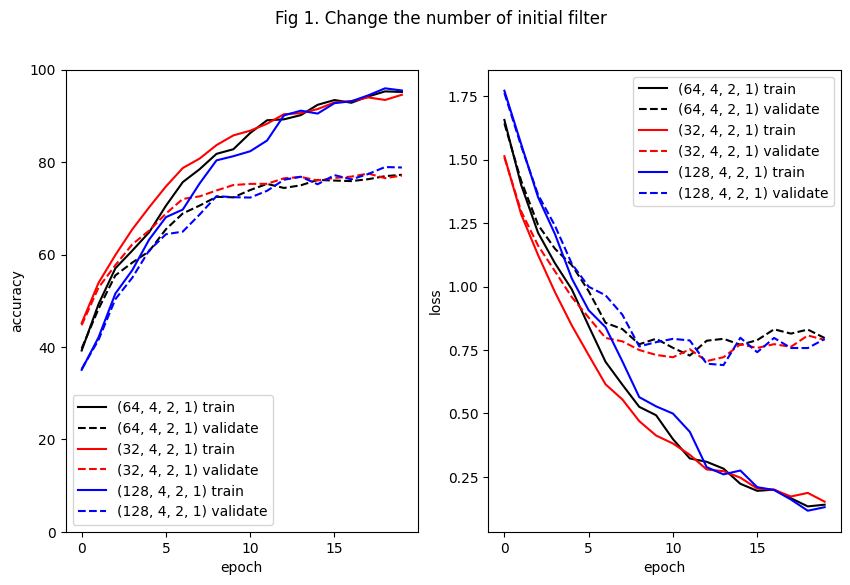

In [29]:
base = (64, 4, 2, 1)
colors = ['r', 'b']
epoch = 20

x = np.arange(epoch)
fig, ax = plt.subplots(1,2,figsize=(10,6))
data = summary[base]
ax[0].plot(x, data[:,0], ls='-', color='k', label=str(base)+' train')
ax[0].plot(x, data[:,2], ls='--', color='k', label=str(base)+' validate')
ax[1].plot(x, data[:,1], ls='-', color='k', label=str(base)+' train')
ax[1].plot(x, data[:,3], ls='--', color='k', label=str(base)+' validate')
count = 0
for nfilter in nfilters:
    if nfilter != base[0]:
        label = (nfilter, base[1], base[2], base[3])
        data = summary[label]
        ax[0].plot(x, data[:,0], ls='-', color=colors[count], label=str(label)+' train')
        ax[0].plot(x, data[:,2], ls='--', color=colors[count], label=str(label)+' validate')
        ax[1].plot(x, data[:,1], ls='-', color=colors[count], label=str(label)+' train')
        ax[1].plot(x, data[:,3], ls='--', color=colors[count], label=str(label)+' validate')
        count += 1
ax[0].legend()
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('accuracy')
ax[0].set_ylim([0,100])
ax[1].legend()
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')
fig.suptitle("Fig 1. Change the number of initial filter")

Decreasing the number of initial filters will slight increase the training and validation accuracy at low epoches, but does not significantly affect the convergence of training and validation accuracy at higher epoches.

Text(0.5, 0.98, 'Fig 2. Change the number of stages')

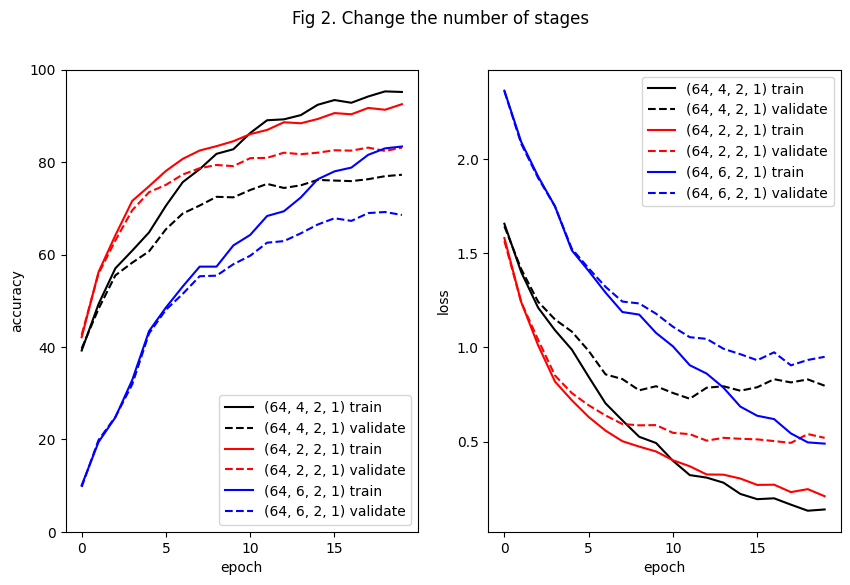

In [31]:
base = (64, 4, 2, 1)
colors = ['r', 'b']
epoch = 20

x = np.arange(epoch)
fig, ax = plt.subplots(1,2,figsize=(10,6))
data = summary[base]
ax[0].plot(x, data[:,0], ls='-', color='k', label=str(base)+' train')
ax[0].plot(x, data[:,2], ls='--', color='k', label=str(base)+' validate')
ax[1].plot(x, data[:,1], ls='-', color='k', label=str(base)+' train')
ax[1].plot(x, data[:,3], ls='--', color='k', label=str(base)+' validate')
count = 0
for nstage in nstages:
    if nstage != base[1]:
        label = (base[0], nstage, base[2], base[3])
        data = summary[label]
        ax[0].plot(x, data[:,0], ls='-', color=colors[count], label=str(label)+' train')
        ax[0].plot(x, data[:,2], ls='--', color=colors[count], label=str(label)+' validate')
        ax[1].plot(x, data[:,1], ls='-', color=colors[count], label=str(label)+' train')
        ax[1].plot(x, data[:,3], ls='--', color=colors[count], label=str(label)+' validate')
        count += 1
ax[0].legend()
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('accuracy')
ax[0].set_ylim([0,100])
ax[1].legend()
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')
fig.suptitle("Fig 2. Change the number of stages")

Increasing the number of stages will significantly slow down the convergence at low epoches, and could lead to overfitting at high epoches, i.e. while the training accuracy of 4 stages is higher than that of 2 stages, its validation accuracy is lower. Too many stages (6) is harmful to both training and validation accuracy.

Text(0.5, 0.98, 'Fig 3. Change the number of convolutions between downsampling')

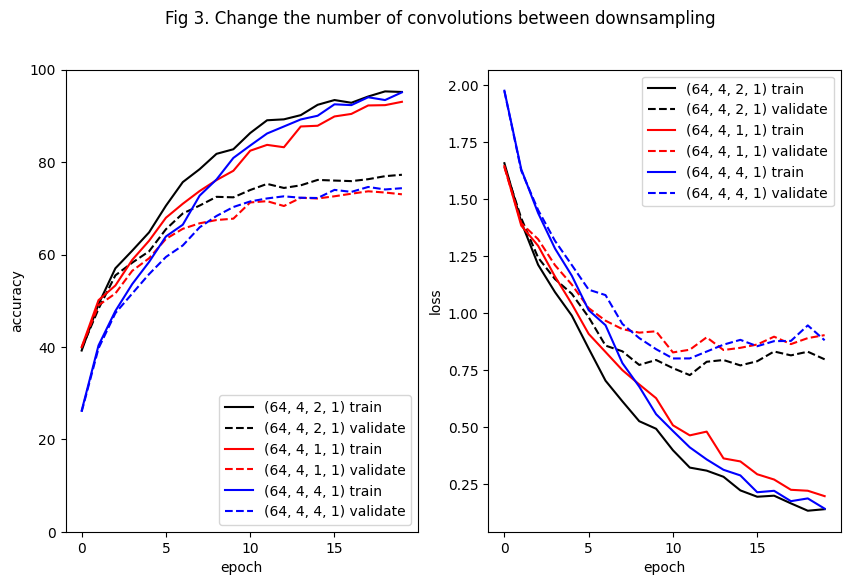

In [32]:
base = (64, 4, 2, 1)
colors = ['r', 'b']
epoch = 20

x = np.arange(epoch)
fig, ax = plt.subplots(1,2,figsize=(10,6))
data = summary[base]
ax[0].plot(x, data[:,0], ls='-', color='k', label=str(base)+' train')
ax[0].plot(x, data[:,2], ls='--', color='k', label=str(base)+' validate')
ax[1].plot(x, data[:,1], ls='-', color='k', label=str(base)+' train')
ax[1].plot(x, data[:,3], ls='--', color='k', label=str(base)+' validate')
count = 0
for nconv in nconvs:
    if nconv != base[2]:
        label = (base[0], base[1], nconv, base[3])
        data = summary[label]
        ax[0].plot(x, data[:,0], ls='-', color=colors[count], label=str(label)+' train')
        ax[0].plot(x, data[:,2], ls='--', color=colors[count], label=str(label)+' validate')
        ax[1].plot(x, data[:,1], ls='-', color=colors[count], label=str(label)+' train')
        ax[1].plot(x, data[:,3], ls='--', color=colors[count], label=str(label)+' validate')
        count += 1
ax[0].legend()
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('accuracy')
ax[0].set_ylim([0,100])
ax[1].legend()
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')
fig.suptitle("Fig 3. Change the number of convolutions between downsampling")

Increasing the number of convolution layer between downsampling slightly slow down the convergence, but does not significantly affect the final convergence and accuracy.

Text(0.5, 0.98, 'Fig 4. Change patch size')

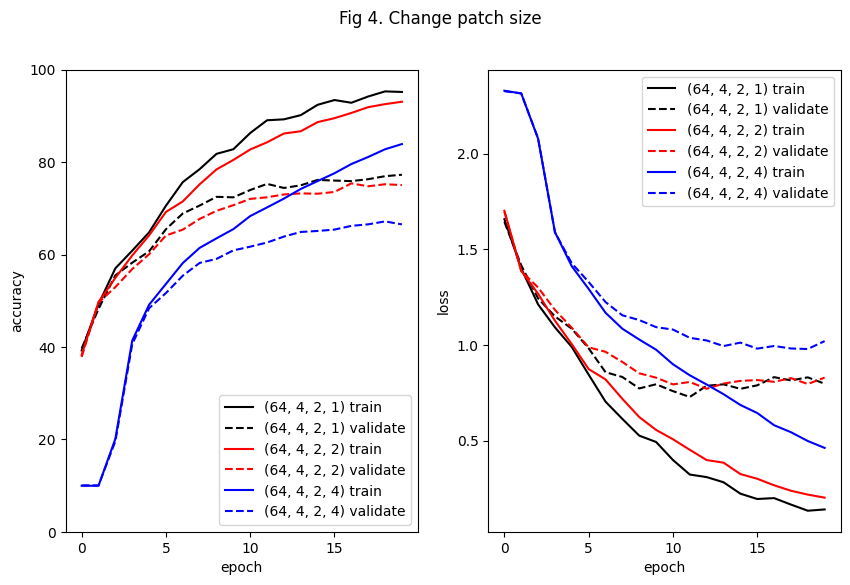

In [33]:
base = (64, 4, 2, 1)
colors = ['r', 'b']
epoch = 20

x = np.arange(epoch)
fig, ax = plt.subplots(1,2,figsize=(10,6))
data = summary[base]
ax[0].plot(x, data[:,0], ls='-', color='k', label=str(base)+' train')
ax[0].plot(x, data[:,2], ls='--', color='k', label=str(base)+' validate')
ax[1].plot(x, data[:,1], ls='-', color='k', label=str(base)+' train')
ax[1].plot(x, data[:,3], ls='--', color='k', label=str(base)+' validate')
count = 0
for patch in patches:
    if patch != base[3]:
        label = (base[0], base[1], base[2], patch)
        data = summary[label]
        ax[0].plot(x, data[:,0], ls='-', color=colors[count], label=str(label)+' train')
        ax[0].plot(x, data[:,2], ls='--', color=colors[count], label=str(label)+' validate')
        ax[1].plot(x, data[:,1], ls='-', color=colors[count], label=str(label)+' train')
        ax[1].plot(x, data[:,3], ls='--', color=colors[count], label=str(label)+' validate')
        count += 1
ax[0].legend()
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('accuracy')
ax[0].set_ylim([0,100])
ax[1].legend()
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')
fig.suptitle("Fig 4. Change patch size")

At low patchify level (1X1 and 2X2), the training and validation accuracies are similar. However, at high patchify level (4X4), the accuracy is lower. It is probably because the input image is only 32X32 in size, so 4X4 patchify is too aggresive and misses many important details. 